In [1]:
import os
import numpy as np
import pandas as pd
import re
import PIL
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, Dense, Concatenate, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import datetime


In [2]:
BASE_DIR = './data/new_plant_diseases/'
TRAIN_DIR = os.path.join('./data/new_plant_diseases/augmented/', "train")
VAL_DIR = os.path.join('./data/new_plant_diseases/augmented/', "valid")
TEST_DIR = os.path.join('./data/new_plant_diseases/', "test")
IMG_SHAPE  = (256, 256)
BATCH_SIZE = 64
print(TRAIN_DIR)

./data/new_plant_diseases/augmented/train


In [27]:
INPUT_DEPTH_MULTIPLIER = 8
BASE_FILTER_COUNT = 32
DENSE_NODES = 512
DROPOUT_PERCENTS = [0.2, 0.2, 0.2]

In [5]:
EPOCHS = 30
PATIENCE = 5
QUEUE_SIZE = 25
PLOTS_DPI = 200

In [6]:
total_train = 0

for d in os.listdir(TRAIN_DIR):
    if not d.startswith('.'): 
        path = os.path.join(TRAIN_DIR, d)
        img_count = len(os.listdir(path))
        total_train += img_count

print(f'\nTotal validation images: {total_train}')


Total validation images: 70296


In [7]:
total_val = 0

for d in os.listdir(VAL_DIR):
    if not d.startswith('.'): 
        path = os.path.join(VAL_DIR, d)
        img_count = len(os.listdir(path))
        total_val += img_count

print(f'\nTotal validation images: {total_val}')


Total validation images: 17575


In [8]:
test_image_data = []
test_image_filenames = []

for img_name in os.listdir(TEST_DIR):
    img_path = os.path.join(TEST_DIR, img_name)
    try:
        img = load_img(img_path, target_size=IMG_SHAPE)
        img_array = img_to_array(img, dtype='uint8')
        test_image_data.append(img_array)
        test_image_filenames.append(img_name)
    except (OSError, ValueError, AttributeError, PIL.UnidentifiedImageError):
        print(f"Invalid image: {img_path}")

test_image_data = np.array(test_image_data) / 255
print(f'\nTotal testing images: {len(test_image_data)}')

Invalid image: ./data/new_plant_diseases/test/.ipynb_checkpoints

Total testing images: 33


In [9]:
train_image_gen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 15,
        width_shift_range = 0.05,
        height_shift_range = 0.05,
        shear_range = 0.05,
        zoom_range = 0.05,
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode = 'reflect'
    )

train_data_gen = train_image_gen.flow_from_directory(
        batch_size = BATCH_SIZE,
        directory = TRAIN_DIR,
        shuffle = True,
        target_size = IMG_SHAPE
    )

Found 70307 images belonging to 38 classes.


In [10]:
val_image_gen = ImageDataGenerator(rescale = 1./255)

val_data_gen = val_image_gen.flow_from_directory(
        batch_size = BATCH_SIZE,
        directory = VAL_DIR,
        shuffle = True,
        target_size = IMG_SHAPE
    )

Found 17580 images belonging to 38 classes.


In [11]:
total_classes = len(os.listdir(TRAIN_DIR))

print(f'\nTotal number of classes: {total_classes}')


Total number of classes: 38


In [12]:
class_name_lookup = {name: index for index, name in train_data_gen.class_indices.items()}

for k, v in class_name_lookup.items():
    print(f"{k:2} : {v}")

 0 : Apple___Apple_scab
 1 : Apple___Black_rot
 2 : Apple___Cedar_apple_rust
 3 : Apple___healthy
 4 : Blueberry___healthy
 5 : Cherry_(including_sour)___Powdery_mildew
 6 : Cherry_(including_sour)___healthy
 7 : Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
 8 : Corn_(maize)___Common_rust_
 9 : Corn_(maize)___Northern_Leaf_Blight
10 : Corn_(maize)___healthy
11 : Grape___Black_rot
12 : Grape___Esca_(Black_Measles)
13 : Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
14 : Grape___healthy
15 : Orange___Haunglongbing_(Citrus_greening)
16 : Peach___Bacterial_spot
17 : Peach___healthy
18 : Pepper,_bell___Bacterial_spot
19 : Pepper,_bell___healthy
20 : Potato___Early_blight
21 : Potato___Late_blight
22 : Potato___healthy
23 : Raspberry___healthy
24 : Soybean___healthy
25 : Squash___Powdery_mildew
26 : Strawberry___Leaf_scorch
27 : Strawberry___healthy
28 : Tomato___Bacterial_spot
29 : Tomato___Early_blight
30 : Tomato___Late_blight
31 : Tomato___Leaf_Mold
32 : Tomato___Septoria_leaf_spot
33 

In [42]:
inputs = tf.keras.Input(shape = (*IMG_SHAPE, 3), name = "Input")
depth_conv_1 = DepthwiseConv2D(2, depth_multiplier = INPUT_DEPTH_MULTIPLIER, padding = "same", activation = "relu")(inputs)
conv_1 = Conv2D(BASE_FILTER_COUNT, 1, activation = "relu")(depth_conv_1)
max_pool_1 = MaxPooling2D()(conv_1)

depth_conv_2 = DepthwiseConv2D(2, padding = "same", activation = "relu")(max_pool_1)
conv_2 = Conv2D(BASE_FILTER_COUNT * 2, 1, activation = "relu")(depth_conv_2)
max_pool_2 = MaxPooling2D()(conv_2)

depth_conv_3 = DepthwiseConv2D(2, padding = "same", activation = "relu")(max_pool_2)
conv_3 = Conv2D(BASE_FILTER_COUNT * 4, 1, activation = "relu")(depth_conv_3)
max_pool_3 = MaxPooling2D()(conv_3)

depth_conv_4 = DepthwiseConv2D(2, padding = "same", activation = "relu")(max_pool_3)
conv_4 = Conv2D(BASE_FILTER_COUNT * 8, 1, activation = "relu")(depth_conv_4)
max_pool_4 = MaxPooling2D()(conv_4)

depth_conv_5 = DepthwiseConv2D(2, padding = "same", activation = "relu")(max_pool_4)
conv_5 = Conv2D(BASE_FILTER_COUNT * 16, 1, activation = "relu")(depth_conv_5)
max_pool_5 = MaxPooling2D()(conv_5)

global_avg_1 = GlobalAveragePooling2D()(max_pool_1)
global_avg_2 = GlobalAveragePooling2D()(max_pool_2)
global_avg_3 = GlobalAveragePooling2D()(max_pool_3)
global_avg_4 = GlobalAveragePooling2D()(max_pool_4)
global_avg_5 = GlobalAveragePooling2D()(max_pool_5)
concatenated = Concatenate()([global_avg_1, global_avg_2, global_avg_3, global_avg_4, global_avg_5])
dropout_1 = Dropout(DROPOUT_PERCENTS[0])(concatenated)
dense_1 = Dense(DENSE_NODES, activation = "relu")(dropout_1)
dropout_2 = Dropout(DROPOUT_PERCENTS[1])(dense_1)
dense_2 = Dense(total_classes, activation = "softmax")(dropout_2)


In [43]:
model = Model(inputs = inputs, outputs = dense_2, name = "new_plant_diseases")

model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
 
model.summary()

Model: "new_plant_diseases"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 depthwise_conv2d_42 (Depth  (None, 256, 256, 24)         120       ['Input[0][0]']               
 wiseConv2D)                                                                                      
                                                                                                  
 conv2d_42 (Conv2D)          (None, 256, 256, 32)         800       ['depthwise_conv2d_42[0][0]'] 
                                                                                                  
 max_pooling2d_42 (MaxPooli  (None, 128, 128, 32)         0         ['conv2d_42[0

In [44]:
earlyStop = EarlyStopping(monitor = 'val_loss', patience = PATIENCE, restore_best_weights = True)
tensorBoard = TensorBoard(log_dir = TB_LOGS, histogram_freq = 1)

In [45]:
%%time

history = model.fit(
    train_data_gen,
    epochs = EPOCHS,
    validation_data = val_data_gen,
    max_queue_size = QUEUE_SIZE,
    callbacks = [earlyStop, tensorBoard]
)

Epoch 1/30
1099/1099 [==============================] - 485s 440ms/step - loss: 2.8079 - accuracy: 0.2160 - val_loss: 2.5753 - val_accuracy: 0.3253
Epoch 2/30
1099/1099 [==============================] - 486s 442ms/step - loss: 2.2598 - accuracy: 0.4368 - val_loss: 5.1458 - val_accuracy: 0.3546
Epoch 3/30
1099/1099 [==============================] - 486s 442ms/step - loss: 48.7260 - accuracy: 0.2870 - val_loss: 146.9282 - val_accuracy: 0.3048
Epoch 4/30
1099/1099 [==============================] - 485s 441ms/step - loss: 25567.2754 - accuracy: 0.2016 - val_loss: 159594.9375 - val_accuracy: 0.2181
Epoch 5/30
1099/1099 [==============================] - 498s 453ms/step - loss: 1959869.6250 - accuracy: 0.1996 - val_loss: 7775611.5000 - val_accuracy: 0.1824
Epoch 6/30
1099/1099 [==============================] - 503s 457ms/step - loss: 31577858.0000 - accuracy: 0.2051 - val_loss: 66181752.0000 - val_accuracy: 0.2307
CPU times: user 46min 26s, sys: 5min 35s, total: 52min 2s
Wall time: 49min

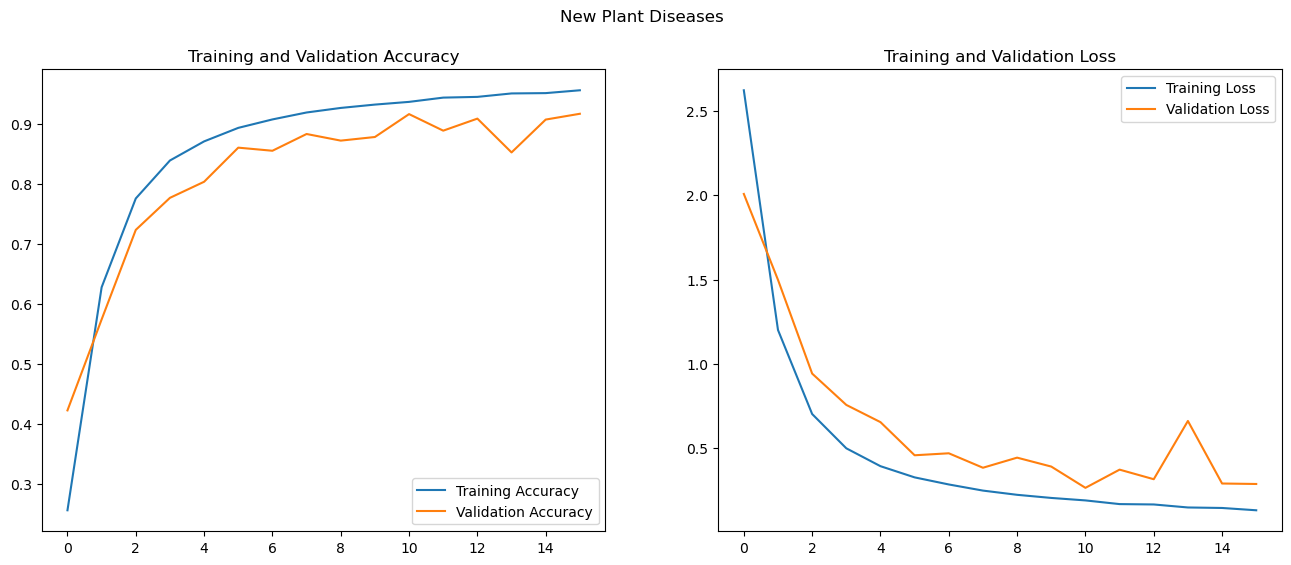

In [101]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize = (16, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

plt.suptitle('New Plant Diseases')

plt.show()

In [102]:
test_pred = np.argmax(model.predict(test_image_data), axis = 1)

2/2 [==============================] - 0s 10ms/step


In [218]:
test_pred_classes = [class_name_lookup[i] for i in test_pred]

predictions_df=pd.DataFrame({
    "Filename": test_image_filenames,
    "Predicted classes": test_pred_classes
    })

In [219]:
def clean_class_name(class_name):
    clean_name = re.sub(r'[^a-zA-Z]', ' ', class_name)  
    clean_name = ' '.join(clean_name.lower().split())  
    return clean_name

class_words_dict = {}
for class_name in class_name_lookup.values():
    clean_name = clean_class_name(class_name)
    words_list = clean_name.split()  
    class_words_dict[class_name] = words_list

def clean_filename(filename):
    filename = re.sub(r'\d', '', filename)  
    filename = re.sub(r'([a-z])([A-Z])', r'\1 \2', filename)  
    filename = re.sub(r'\.JPG$', '', filename)  
    filename = re.sub(r'\W', ' ', filename)  
    filename = filename.lower()
    filename = filename.split(' ')
    return filename

cleaned_filenames = [clean_filename(filename) for filename in predictions_df['Filename']]

predictions_df['True classes'] = None

for i, words_list in enumerate(cleaned_filenames):
    matching_classes = [idx for idx, words_list_class in class_words_dict.items() if all(word in words_list_class for word in words_list)]
    if matching_classes:
        predictions_df.at[i, 'True classes'] = matching_classes[0]

predictions_df

Filename  \
0               AppleScab3.JPG   
1       TomatoEarlyBlight2.JPG   
2       TomatoEarlyBlight3.JPG   
3           PotatoHealthy1.JPG   
4               AppleScab2.JPG   
5       TomatoEarlyBlight1.JPG   
6           PotatoHealthy2.JPG   
7               AppleScab1.JPG   
8       TomatoEarlyBlight4.JPG   
9       TomatoEarlyBlight5.JPG   
10      TomatoEarlyBlight6.JPG   
11      PotatoEarlyBlight4.JPG   
12      PotatoEarlyBlight5.JPG   
13      PotatoEarlyBlight2.JPG   
14      PotatoEarlyBlight3.JPG   
15      PotatoEarlyBlight1.JPG   
16  TomatoYellowCurlVirus2.JPG   
17  TomatoYellowCurlVirus3.JPG   
18  TomatoYellowCurlVirus1.JPG   
19          TomatoHealthy4.JPG   
20  TomatoYellowCurlVirus4.JPG   
21          TomatoHealthy1.JPG   
22  TomatoYellowCurlVirus5.JPG   
23          TomatoHealthy3.JPG   
24          TomatoHealthy2.JPG   
25  TomatoYellowCurlVirus6.JPG   
26         AppleCedarRust2.JPG   
27         CornCommonRust1.JPG   
28         AppleCedarRust3.JPG   
29         AppleCedarRust1.JPG   
30         CornCommonRust2.JPG   
31         CornCommonRust3.JPG   
32         AppleCedarRust4.JPG   

                                    Predicted classes  \
0   Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...   
1                               Tomato___Early_blight   
2                               Tomato___Early_blight   
3                              Pepper,_bell___healthy   
4                                  Apple___Apple_scab   
5                               Tomato___Early_blight   
6                              Pepper,_bell___healthy   
7            Cherry_(including_sour)___Powdery_mildew   
8                               Tomato___Early_blight   
9                               Tomato___Early_blight   
10                              Tomato___Early_blight   
11                              Potato___Early_blight   
12                              Potato___Early_blight   
13                              Potato___Early_blight   
14                              Potato___Early_blight   
15                              Potato___Early_blight   
16             Tomato___Tomato_Yellow_Leaf_Curl_Virus   
17             Tomato___Tomato_Yellow_Leaf_Curl_Virus   
18             Tomato___Tomato_Yellow_Leaf_Curl_Virus   
19                                   Tomato___healthy   
20             Tomato___Tomato_Yellow_Leaf_Curl_Virus   
21                                   Tomato___healthy   
22             Tomato___Tomato_Yellow_Leaf_Curl_Virus   
23                                   Tomato___healthy   
24                            Tomato___Bacterial_spot   
25             Tomato___Tomato_Yellow_Leaf_Curl_Virus   
26                           Apple___Cedar_apple_rust   
27                        Corn_(maize)___Common_rust_   
28                           Apple___Cedar_apple_rust   
29                           Apple___Cedar_apple_rust   
30                        Corn_(maize)___Common_rust_   
31                        Corn_(maize)___Common_rust_   
32                           Apple___Cedar_apple_rust   

                              True classes  
0                       Apple___Apple_scab  
1                    Tomato___Early_blight  
2                    Tomato___Early_blight  
3                         Potato___healthy  
4                       Apple___Apple_scab  
5                    Tomato___Early_blight  
6                         Potato___healthy  
7                       Apple___Apple_scab  
8                    Tomato___Early_blight  
9                    Tomato___Early_blight  
10                   Tomato___Early_blight  
11                   Potato___Early_blight  
12                   Potato___Early_blight  
13                   Potato___Early_blight  
14                   Potato___Early_blight  
15                   Potato___Early_blight  
16  Tomato___Tomato_Yellow_Leaf_Curl_Virus  
17  Tomato___Tomato_Yellow_Leaf_Curl_Virus  
18  Tomato___Tomato_Yellow_Leaf_Curl_Virus  
19                        

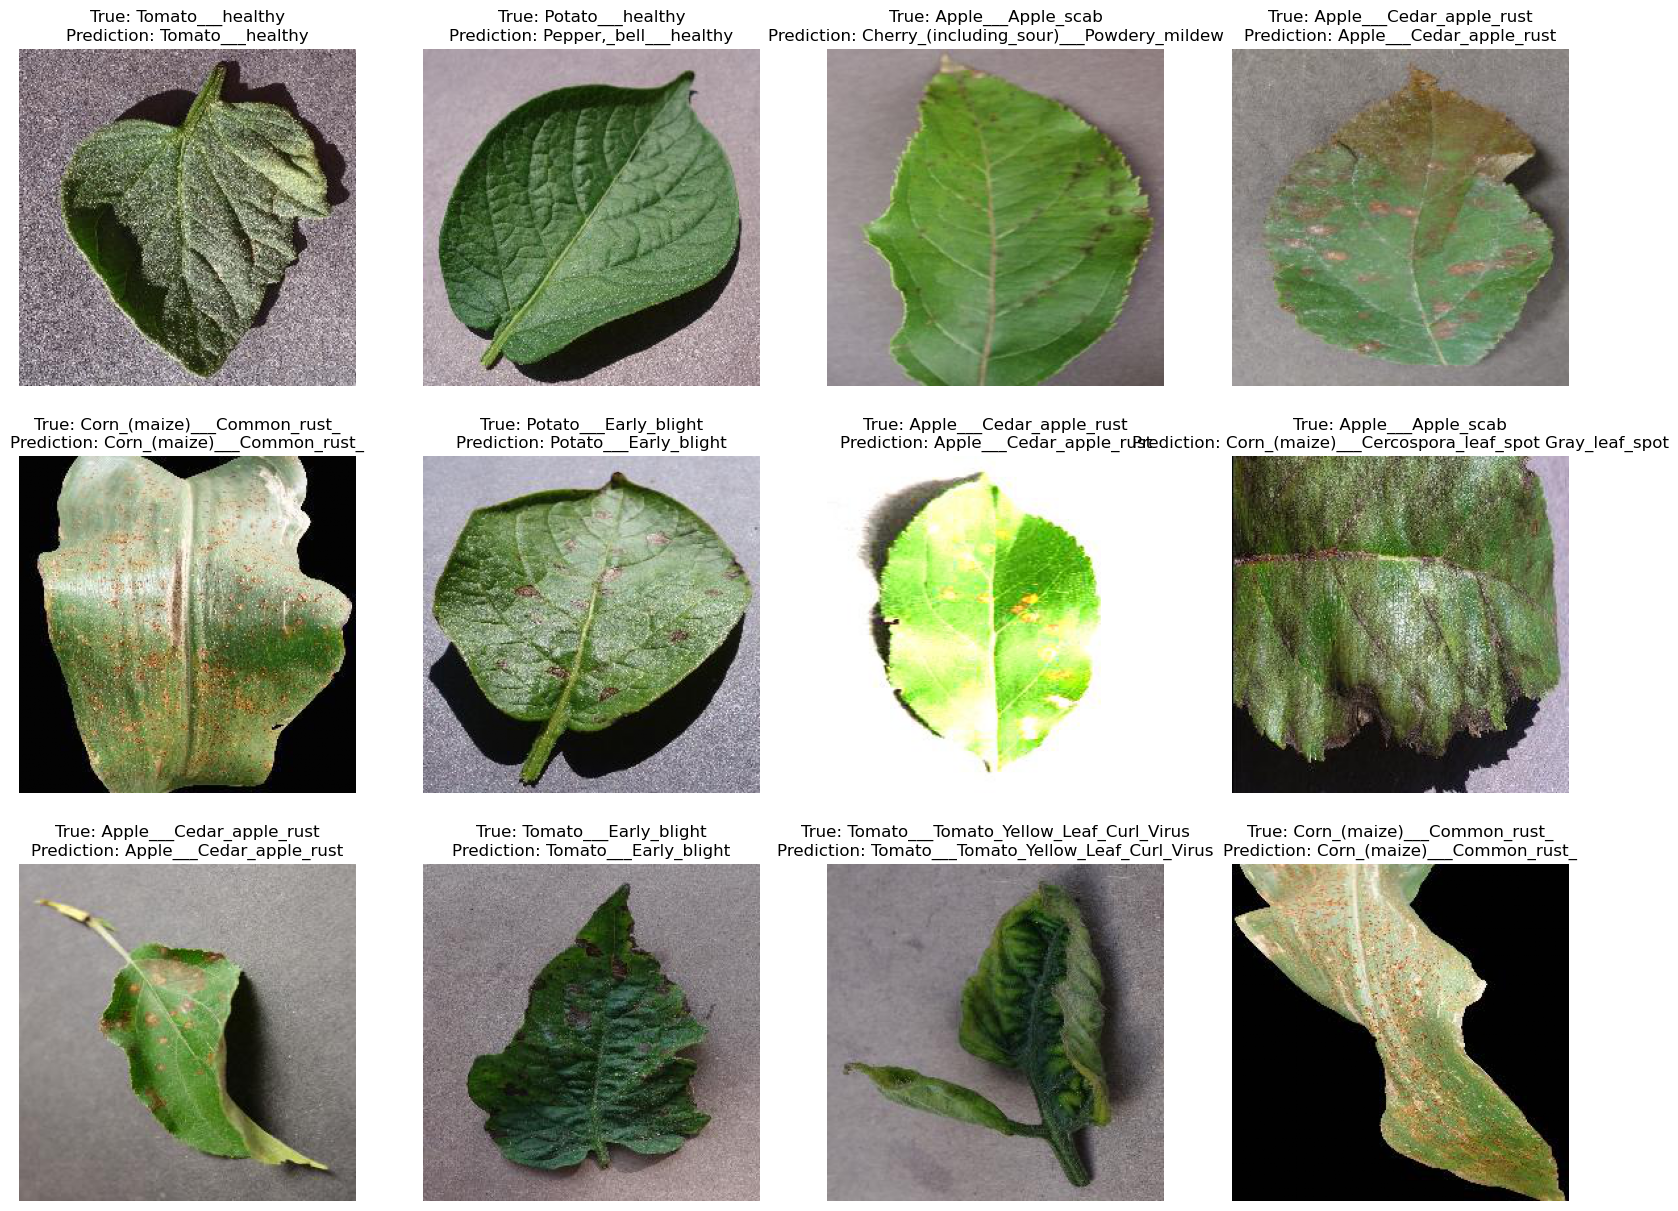

In [222]:
import random
import matplotlib.pyplot as plt

shuffled_indices = list(range(len(test_image_data)))
random.shuffle(shuffled_indices)

plt.subplots(nrows=3, ncols=4, figsize=(20, 15))

for i in range(12):
    idx = shuffled_indices[i] 
    plt.subplot(3, 4, i + 1)
    plt.axis(False)
    plt.grid(False)
    plt.imshow(test_image_data[idx])
    plt.title(f"True: {predictions_df['True classes'].iloc[idx]}\nPrediction: {predictions_df['Predicted classes'].iloc[idx]}")

plt.show()


In [224]:
from sklearn.metrics import classification_report
class_report = classification_report(predictions_df['True classes'], predictions_df['Predicted classes'])
print(class_report)

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      0.33      0.50         3
                          Apple___Cedar_apple_rust       1.00      1.00      1.00         4
          Cherry_(including_sour)___Powdery_mildew       0.00      0.00      0.00         0
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00         0
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00         3
                            Pepper,_bell___healthy       0.00      0.00      0.00         0
                             Potato___Early_blight       1.00      1.00      1.00         5
                                  Potato___healthy       0.00      0.00      0.00         2
                           Tomato___Bacterial_spot       0.00      0.00      0.00         0
                             Tomato___Early_blight       1.00      1.00      1.

/Users/aurore/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aurore/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aurore/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/au

In [228]:
evaluation_data_gen = val_image_gen.flow_from_directory(
        batch_size = BATCH_SIZE,
        directory = VAL_DIR,
        shuffle = False,
        target_size = IMG_SHAPE
    )

Found 17580 images belonging to 38 classes.


2023-12-18 13:01:45.852467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


275/275 [==============================] - 143s 518ms/step


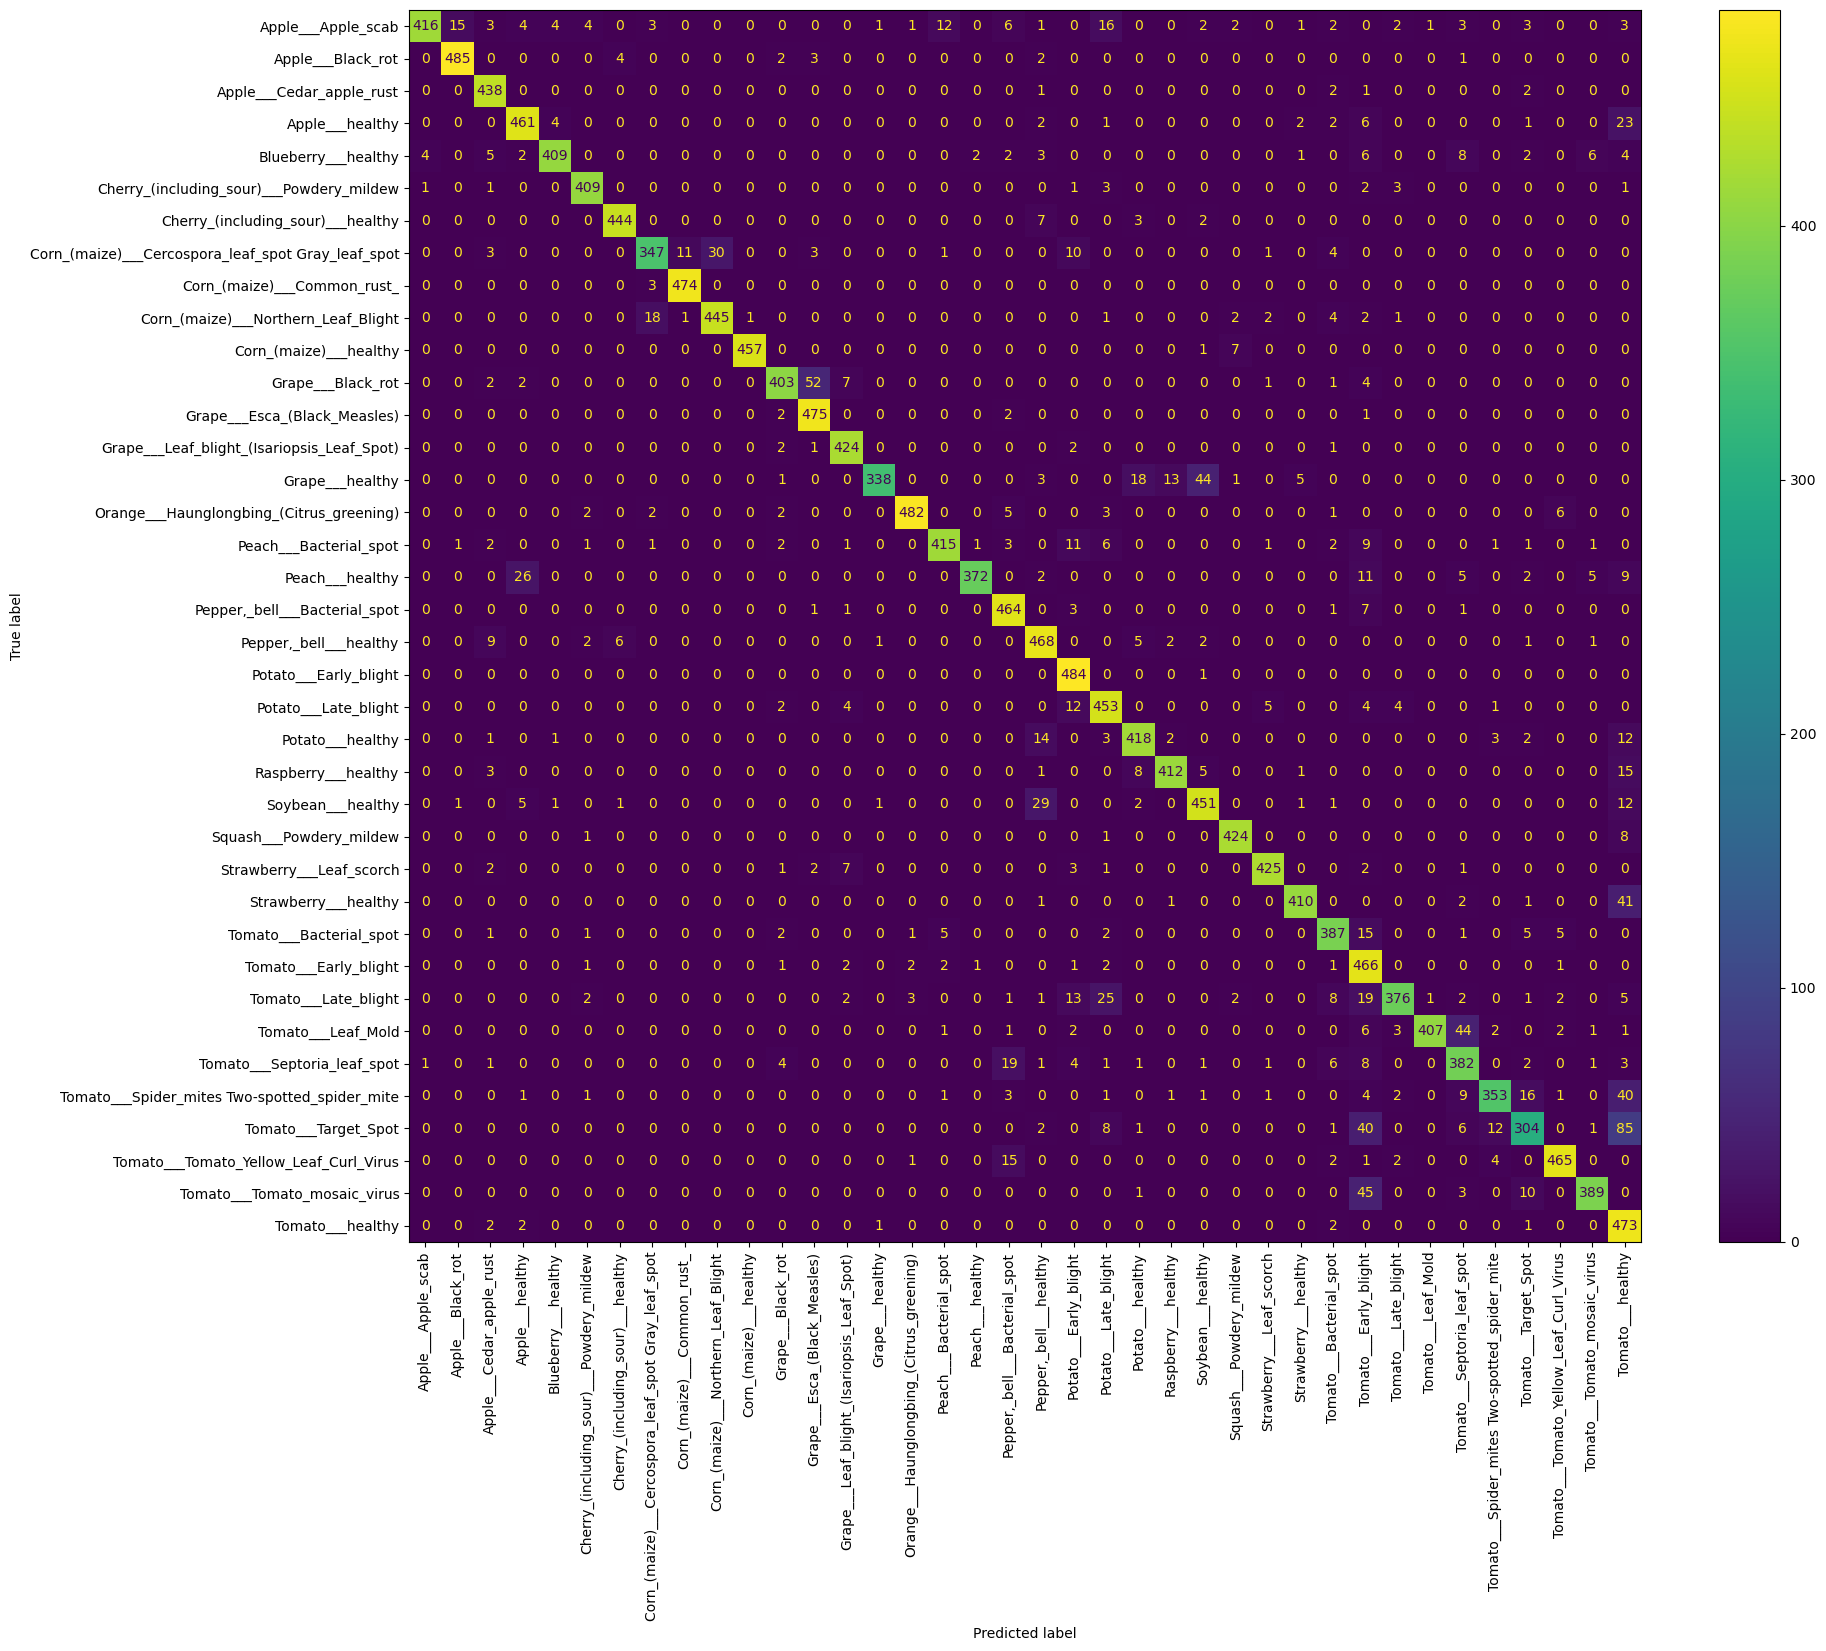

In [229]:
val_true = evaluation_data_gen.classes
val_pred = np.argmax(model.predict(evaluation_data_gen), axis = 1)

_, ax = plt.subplots(figsize = (20, 16))

ConfusionMatrixDisplay(confusion_matrix(val_true, val_pred, labels = list(class_name_lookup.keys())),
                        display_labels = list(class_name_lookup.values())
                        ).plot(ax = ax, xticks_rotation = 'vertical')
                        
plt.show()

In [237]:
conf_matrix = confusion_matrix(val_true, val_pred)
total_images_per_class = conf_matrix.sum(axis=1)
correct_predictions_per_class = np.diag(conf_matrix)
percentage_correct_predictions = (correct_predictions_per_class / total_images_per_class) * 100

data = {
    'Classe': list(class_name_lookup.values()),
    'Pourcentage de valeurs correctement prédites': percentage_correct_predictions.round(2)
}

df = pd.DataFrame(data)
df


Classe  \
0                                  Apple___Apple_scab   
1                                   Apple___Black_rot   
2                            Apple___Cedar_apple_rust   
3                                     Apple___healthy   
4                                 Blueberry___healthy   
5            Cherry_(including_sour)___Powdery_mildew   
6                   Cherry_(including_sour)___healthy   
7   Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...   
8                         Corn_(maize)___Common_rust_   
9                 Corn_(maize)___Northern_Leaf_Blight   
10                             Corn_(maize)___healthy   
11                                  Grape___Black_rot   
12                       Grape___Esca_(Black_Measles)   
13         Grape___Leaf_blight_(Isariopsis_Leaf_Spot)   
14                                    Grape___healthy   
15           Orange___Haunglongbing_(Citrus_greening)   
16                             Peach___Bacterial_spot   
17                                    Peach___healthy   
18                      Pepper,_bell___Bacterial_spot   
19                             Pepper,_bell___healthy   
20                              Potato___Early_blight   
21                               Potato___Late_blight   
22                                   Potato___healthy   
23                                Raspberry___healthy   
24                                  Soybean___healthy   
25                            Squash___Powdery_mildew   
26                           Strawberry___Leaf_scorch   
27                               Strawberry___healthy   
28                            Tomato___Bacterial_spot   
29                              Tomato___Early_blight   
30                               Tomato___Late_blight   
31                                 Tomato___Leaf_Mold   
32                        Tomato___Septoria_leaf_spot   
33      Tomato___Spider_mites Two-spotted_spider_mite   
34                               Tomato___Target_Spot   
35             Tomato___Tomato_Yellow_Leaf_Curl_Virus   
36                       Tomato___Tomato_mosaic_virus   
37                                   Tomato___healthy   

    Pourcentage de valeurs correctement prédites  
0                                          82.38  
1                                          97.59  
2                                          98.65  
3                                          91.83  
4                                          90.09  
5                                          97.15  
6                                          97.37  
7                                          84.63  
8                                          99.37  
9                                          93.29  
10                                         98.28  
11                                         85.38  
12                                         98.96  
13                                         98.60  
14                                         79.91  
15                                         95.83  
16                                         90.41  
17                                         86.11  
18                                         97.07  
19                                         94.16  
20                                         99.79  
21                                         93.40  
22                                         91.67  
23                                         92.58  
24                                         89.31  
25                                         97.70  
26                                         95.72  
27                                         89.91  
28                                         91.06  
29                                         97.08  
30                                         81.21  
31                                         86.60  
32                                         87.61  
33                                         81.15  
34                                    

In [238]:
from sklearn.metrics import classification_report
class_report = classification_report(val_true, val_pred, labels = list(class_name_lookup.keys()))
print(class_report)

              precision    recall  f1-score   support

           0       0.99      0.82      0.90       505
           1       0.97      0.98      0.97       497
           2       0.93      0.99      0.96       444
           3       0.92      0.92      0.92       502
           4       0.98      0.90      0.94       454
           5       0.96      0.97      0.97       421
           6       0.98      0.97      0.97       456
           7       0.93      0.85      0.89       410
           8       0.98      0.99      0.98       477
           9       0.94      0.93      0.93       477
          10       1.00      0.98      0.99       465
          11       0.95      0.85      0.90       472
          12       0.88      0.99      0.93       480
          13       0.95      0.99      0.97       430
          14       0.99      0.80      0.88       423
          15       0.98      0.96      0.97       503
          16       0.95      0.90      0.93       459
          17       0.99    

In [239]:
import itertools
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    if(conf_matrix[i,j] >20 and i!=j):
        print("La classe {0} a souvent été prise pour la classe {1}".format(i,j))


La classe 3 a souvent été prise pour la classe 37
La classe 7 a souvent été prise pour la classe 9
La classe 11 a souvent été prise pour la classe 12
La classe 14 a souvent été prise pour la classe 24
La classe 17 a souvent été prise pour la classe 3
La classe 24 a souvent été prise pour la classe 19
La classe 27 a souvent été prise pour la classe 37
La classe 30 a souvent été prise pour la classe 21
La classe 31 a souvent été prise pour la classe 32
La classe 33 a souvent été prise pour la classe 37
La classe 34 a souvent été prise pour la classe 29
La classe 34 a souvent été prise pour la classe 37
La classe 36 a souvent été prise pour la classe 29


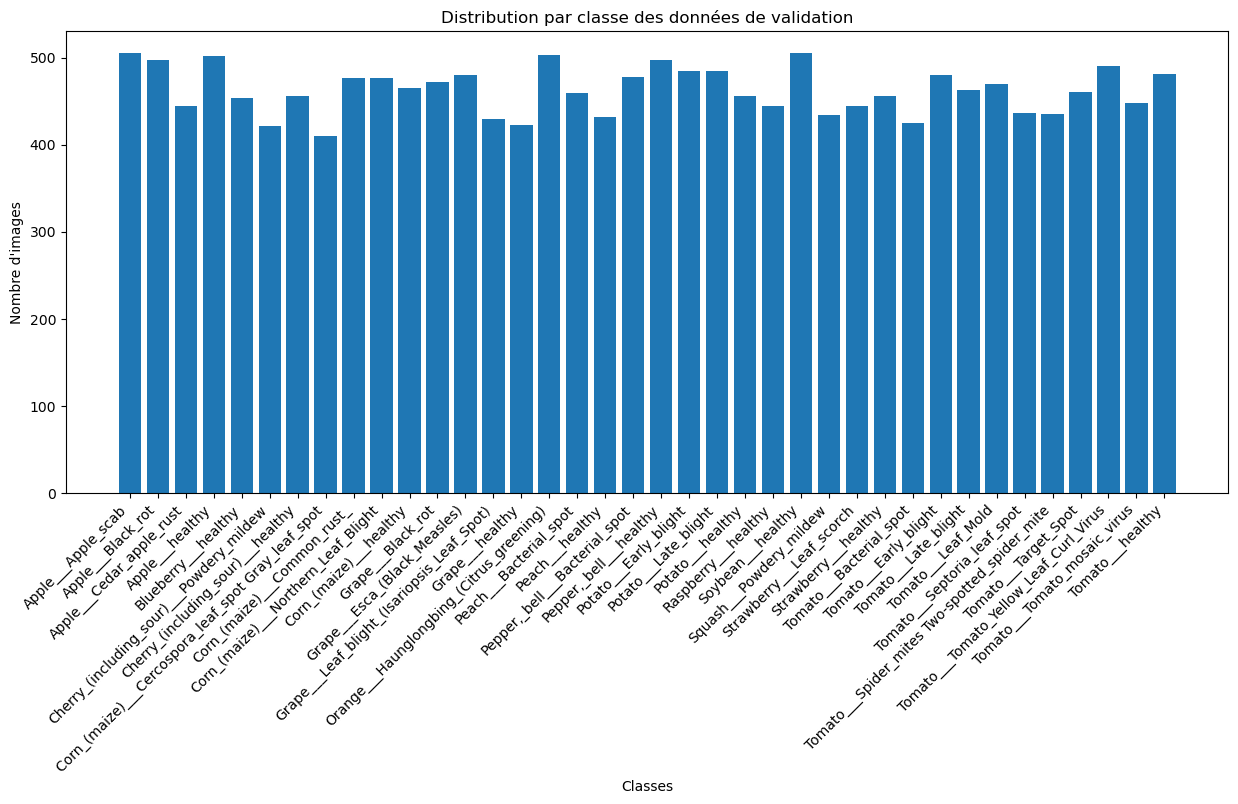

In [124]:
class_counts_val = evaluation_data_gen.classes
unique_val, counts_val = np.unique(class_counts_val, return_counts=True)

class_names_val = list(evaluation_data_gen.class_indices.keys())

plt.figure(figsize=(15, 6))
plt.bar(class_names_val, counts_val)
plt.xlabel('Classes')
plt.ylabel("Nombre d'images")
plt.title('Distribution par classe des données de validation')
plt.xticks(rotation=45, ha='right')
plt.show()

In [125]:
evaluation_data_gen = train_image_gen.flow_from_directory(
        batch_size = BATCH_SIZE,
        directory = TRAIN_DIR,
        shuffle = False,
        target_size = IMG_SHAPE
    )

Found 70300 images belonging to 38 classes.


2023-12-14 12:33:24.302915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1099/1099 [==============================] - 1079s 982ms/step


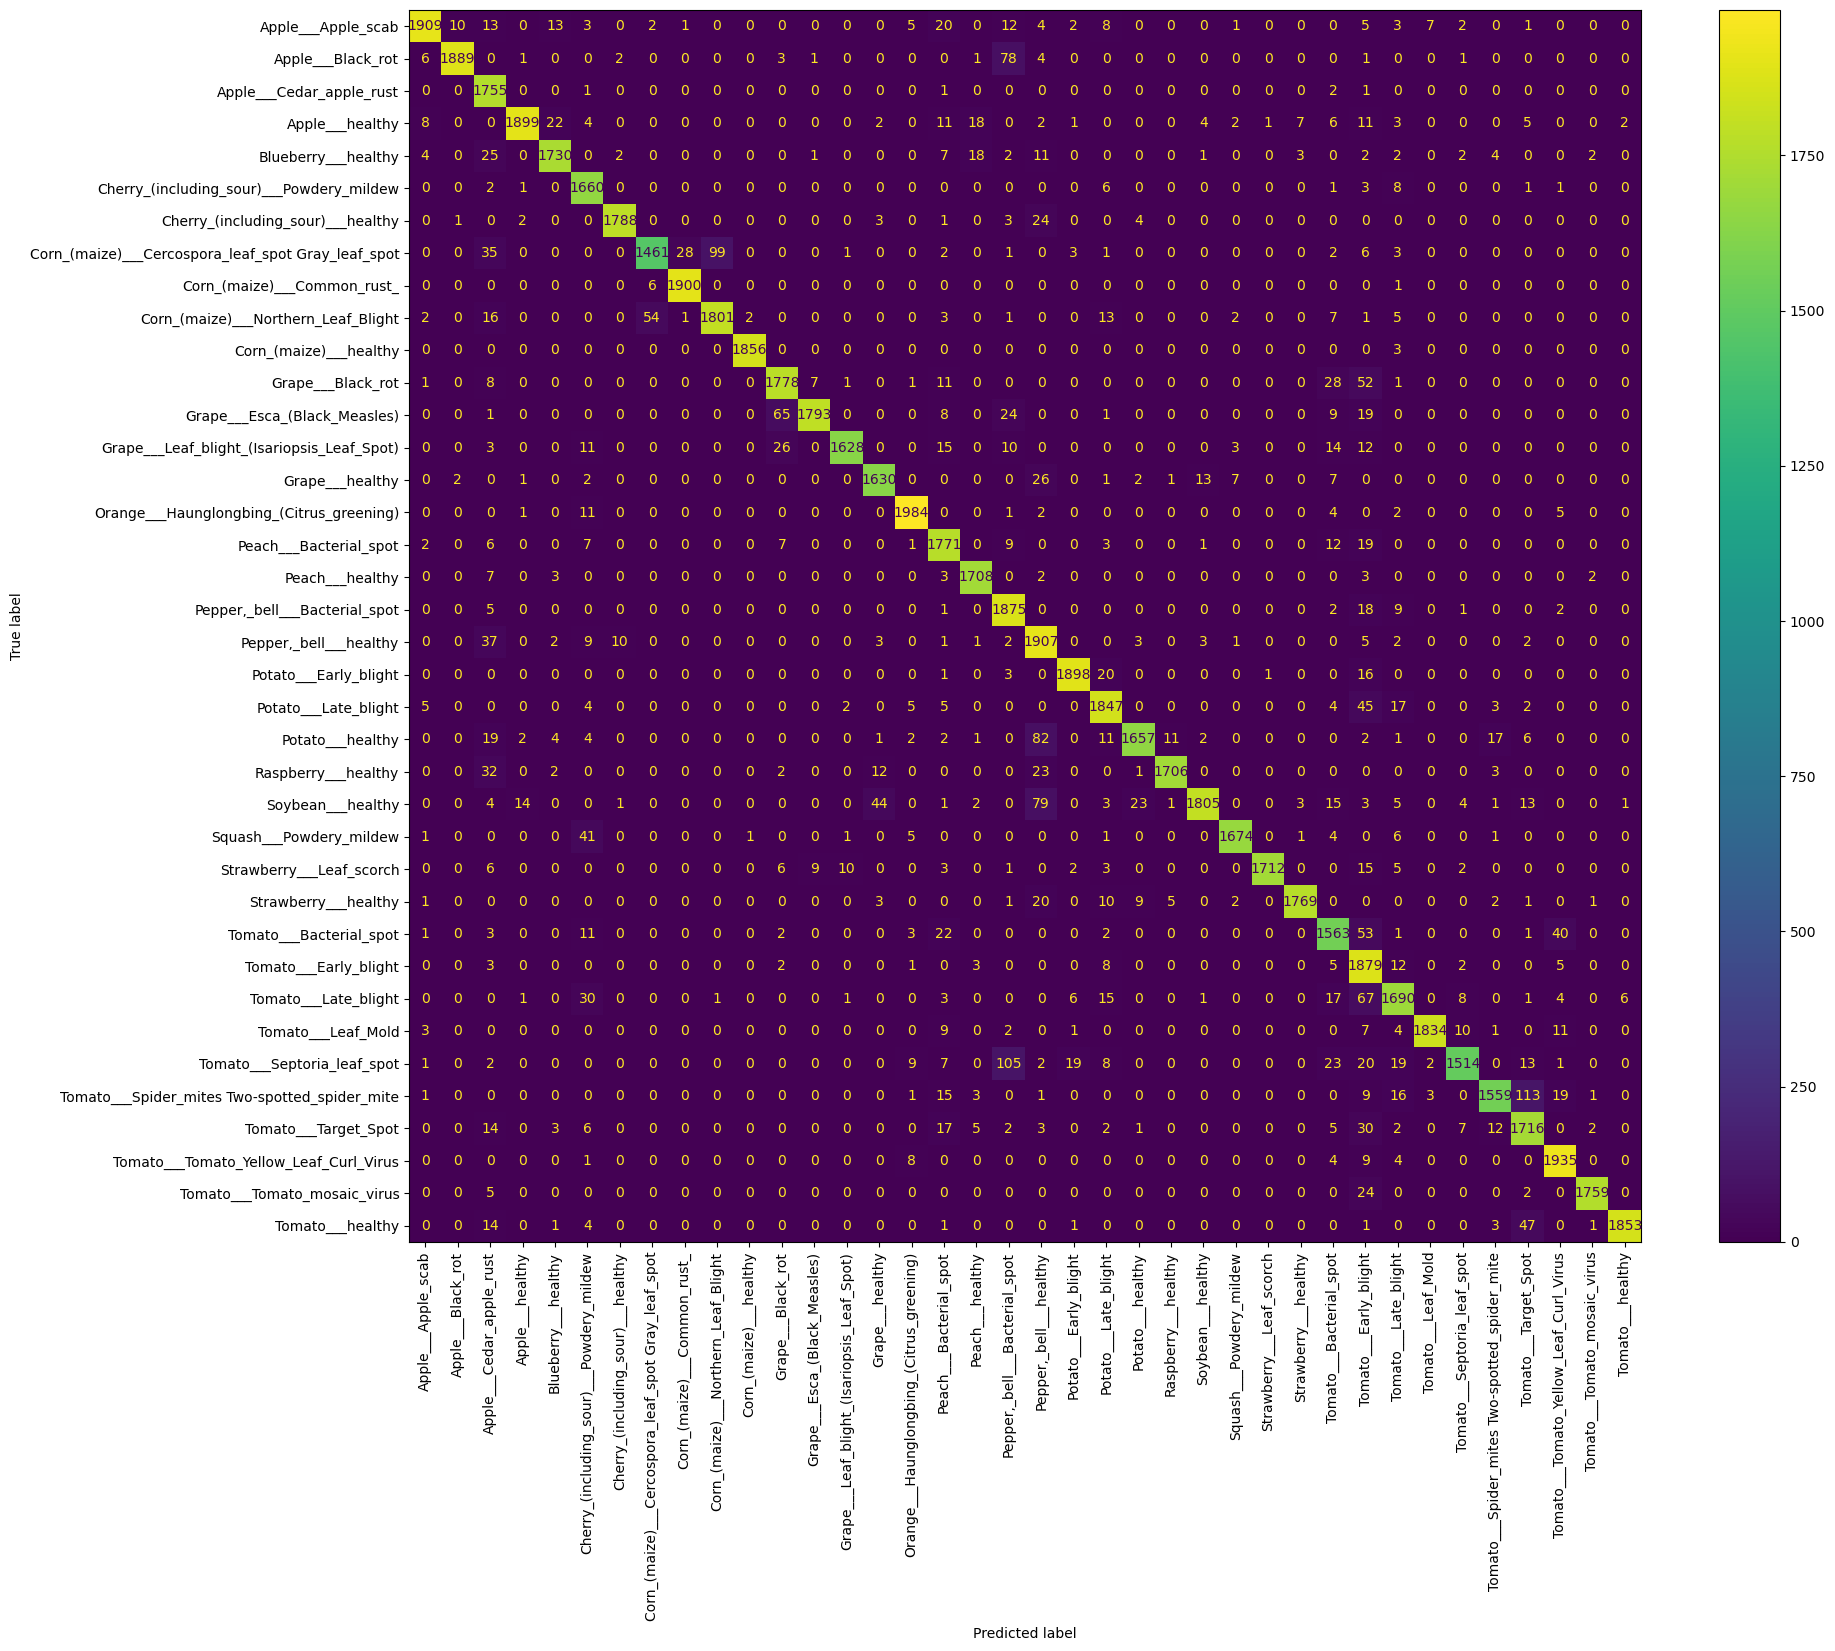

In [126]:
val_true = evaluation_data_gen.classes
val_pred = np.argmax(model.predict(evaluation_data_gen), axis = 1)

_, ax = plt.subplots(figsize = (20, 16))

ConfusionMatrixDisplay(confusion_matrix(val_true, val_pred, labels = list(class_name_lookup.keys())),
                        display_labels = list(class_name_lookup.values())
                        ).plot(ax = ax, xticks_rotation = 'vertical')
                        
plt.show()

In [127]:
conf_matrix = confusion_matrix(val_true, val_pred)
total_images_per_class = conf_matrix.sum(axis=1)
correct_predictions_per_class = np.diag(conf_matrix)
percentage_correct_predictions = (correct_predictions_per_class / total_images_per_class) * 100

data = {
    'Classe': list(class_name_lookup.values()),
    'Pourcentage de valeurs correctement prédites': percentage_correct_predictions.round(2)
}

df = pd.DataFrame(data)
df

Classe  \
0                                  Apple___Apple_scab   
1                                   Apple___Black_rot   
2                            Apple___Cedar_apple_rust   
3                                     Apple___healthy   
4                                 Blueberry___healthy   
5            Cherry_(including_sour)___Powdery_mildew   
6                   Cherry_(including_sour)___healthy   
7   Corn_(maize)___Cercospora_leaf_spot Gray_leaf_...   
8                         Corn_(maize)___Common_rust_   
9                 Corn_(maize)___Northern_Leaf_Blight   
10                             Corn_(maize)___healthy   
11                                  Grape___Black_rot   
12                       Grape___Esca_(Black_Measles)   
13         Grape___Leaf_blight_(Isariopsis_Leaf_Spot)   
14                                    Grape___healthy   
15           Orange___Haunglongbing_(Citrus_greening)   
16                             Peach___Bacterial_spot   
17                                    Peach___healthy   
18                      Pepper,_bell___Bacterial_spot   
19                             Pepper,_bell___healthy   
20                              Potato___Early_blight   
21                               Potato___Late_blight   
22                                   Potato___healthy   
23                                Raspberry___healthy   
24                                  Soybean___healthy   
25                            Squash___Powdery_mildew   
26                           Strawberry___Leaf_scorch   
27                               Strawberry___healthy   
28                            Tomato___Bacterial_spot   
29                              Tomato___Early_blight   
30                               Tomato___Late_blight   
31                                 Tomato___Leaf_Mold   
32                        Tomato___Septoria_leaf_spot   
33      Tomato___Spider_mites Two-spotted_spider_mite   
34                               Tomato___Target_Spot   
35             Tomato___Tomato_Yellow_Leaf_Curl_Virus   
36                       Tomato___Tomato_mosaic_virus   
37                                   Tomato___healthy   

    Pourcentage de valeurs correctement prédites  
0                                          94.46  
1                                          95.07  
2                                          99.72  
3                                          94.57  
4                                          95.26  
5                                          98.63  
6                                          97.92  
7                                          88.98  
8                                          99.63  
9                                          94.39  
10                                         99.84  
11                                         94.17  
12                                         93.39  
13                                         94.54  
14                                         96.34  
15                                         98.71  
16                                         96.35  
17                                         98.84  
18                                         98.01  
19                                         95.93  
20                                         97.89  
21                                         95.26  
22                                         90.84  
23                                         95.79  
24                                         89.27  
25                                         96.43  
26                                         96.51  
27                                         96.98  
28                                         91.83  
29                                         97.86  
30                                         91.30  
31                                         97.45  
32                                         86.76  
33                                         89.55  
34                                    